In [1]:
from lightkurve import KeplerTargetPixelFile as ktpf

In [2]:
import numpy as np
try:
    tpf = ktpf.from_archive('211416749', campaign = 5, cadence='long')
except:
    pass
tpf

KeplerTargetPixelFile Object (ID: 211416749)

In [3]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers().correct(windows=10).remove_outliers()

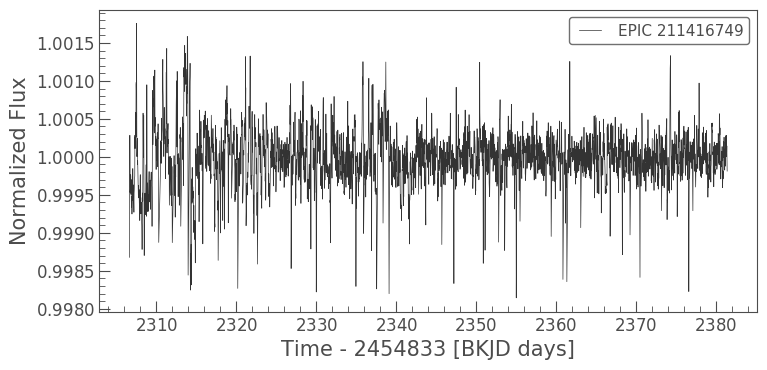

In [4]:
lc.plot()

## Lets do the unit verification by hand so we understand it better

In [16]:
from astropy import units as u
nyquist = 0.5 * (1./((np.median(np.diff(lc.time))*u.day).to(u.second))).to(u.microhertz).value
df = (1./((np.nanmax(lc.time - lc.time[0]))*u.day).to(u.second)).to(u.microhertz).value


In [18]:
frequencies = np.arange(df, nyquist, df) 
frequencies = u.Quantity(frequencies, u.microhertz)

In [7]:
from astropy.stats import LombScargle    
lombscargle = LombScargle((lc.time * u.day).to(u.second), lc.flux * 1e6)
powers = lombscargle.power(frequencies, method="fast", normalization="psd")

## Lets try and do this from 'first principles'

In [40]:
flux = lc.flux
time_days = lc.time

Get the definitive time and flux arrays

In [41]:
sel = np.isfinite(flux) #Check theres no gaps
time = 24. * 60. * 60. * time_days[sel] #Convert days to seconds
time -= time[0] #Normalise the time data
flux = flux[sel]

Calculate the frequency resolution, the Nyquist frequency, and the frequency grid

In [42]:
df = 1. / np.nanmax(time)
nyquist = 1./(2.*np.median(np.diff(time)))
f = np.arange(df, nyquist, df) #Define frequency array

Calculate the Power Spectral Density

In [8]:
from astropy.stats import LombScargle
ls = LombScargle(time, flux*1e6)
p = ls.power(f, method='fast', normalization='psd')

Normalize the power spectral density and express in terms of $\mu Hz$

In [9]:
norm = np.std(flux)**2 / np.sum(p)
p *= norm      #Normalize
p /= df * 1e6  #Set in units of ppm^2/uHz

In [10]:
fig, ax = plt.subplots()
# ax = lc.periodogram().plot(alpha=.5, label='lightkurve')
ax.plot(f*1e6, p/day / len(time), alpha=.5, label='K2pipes/TDA')
ax.legend()
plt.show()

NameError: name 'plt' is not defined